In [16]:
import mdf_iter               # MDF4 데이터 불러오는 라이브러리
import canedge_browser        # 로컬 또는 S3에 저장된 데이터 가져오는 라이브러리
import can_decoder            # 데이터를 복호화하는 라이브러리
import numpy as np
import pandas as pd           # 데이터분석 라이브러리
from datetime import datetime, timezone  # 날짜와 시간 데이터를 가져올 수 있는 파이썬 라이브러리
from utils import setup_fs, load_dbc_files, restructure_data, add_custom_sig, ProcessData # 폴더 내 위치한 Custom 라이브러리

In [17]:
# 필수 라이브러리 설치
# !pip install -r api-examples/examples/data-processing/requirements.txt

In [18]:
# specify devices to process (from local/S3), DBC files and start time
# devices = ["LOG/test"]
# dbc_paths = ["dbc_files/CSS-Electronics-OBD2-v1.4.dbc"]
# s3 또는 로컬에 저장한 파일을 불러옵니다. 
# 만약 s3에 저장한 경우라면, s3=True를 입력합니다.

# 시작시간
# start = datetime(year=2020, month=1, day=13, hour=0, tzinfo=timezone.utc)

In [19]:
#  load, DBC decode and print MF4 log files

# devices MF4 파일을 넣는곳
devices = ["LOG/958D2219"]
# dbc_paths dbc 파일을 넣는곳
dbc_paths = ["dbc_files/CSS-Electronics-OBD2-v1.4.dbc"]
# devices = ["LOG/test"]
# dbc_paths = ["dbc_files/tp_j1939.dbc"]

db_list = load_dbc_files(dbc_paths)
fs = setup_fs(s3=False, key="", secret="", endpoint="")

log_files = canedge_browser.get_log_files(fs, devices)

print(db_list)
print(log_files)
proc = ProcessData(fs, db_list)

df_phys_all = pd.DataFrame()


# for log_file in log_files:
#    df_raw,df_id = proc.get_raw_data(log_file)
#    df_phys = proc.extract_phys(df_raw)
#    print(df_phys)


['/LOG/958D2219/00002501/00000001.MF4', '/LOG/958D2219/00002501/00002081.MF4', '/LOG/958D2219/00002501/00002082.MF4']


In [20]:
# setup filesystem (local/S3), load DBC files and list log files for processing
fs = setup_fs(s3=False, key="", secret="", endpoint="")


In [21]:
# 리스트형태로 입력한 dbc 파일경로를 받아 list를 생성합니다
db_list = load_dbc_files(dbc_paths)
# canedge_browser.get_log_files는 조건에 맞는 로그 파일 경로를 List로 반환합니다.
log_files = canedge_browser.get_log_files(fs, devices)
print(f"Found a total of {len(log_files)} log files")

print(db_list)
print(log_files)


Found a total of 3 log files
['/LOG/958D2219/00002501/00000001.MF4', '/LOG/958D2219/00002501/00002081.MF4', '/LOG/958D2219/00002501/00002082.MF4']


In [22]:
proc = ProcessData(fs, db_list, signals=[])

# 데이터 프레임을 먼저만든뒤
df_phys_all = pd.DataFrame()

# 로그파일 리스트의 데이터를 불러와 데이터프레임에 append
for log_file in log_files:
    # .get_raw_data 는 df_raw 값과 device_id 값을 튜플 형태로 리턴
    df_raw,device_id = proc.get_raw_data(log_file)
    # raw 값저장-> phys 값으로 변환 
    df_phys = proc.extract_phys(df_raw)
    # 로그요약을 출력
    proc.print_log_summary(device_id,log_file,df_phys)

    df_phys_all = df_phys_all.append(df_phys)




--------------- 
Device: 2C4E8905 | Log file: /LOG/958D2219/00002501/00000001.MF4 [Extracted 378 decoded frames]
Period: 2022-06-13 08:14:53.515350+00:00 - 2022-06-13 08:15:56.004600+00:00


--------------- 
Device: 958D2219 | Log file: /00002501/00002081.MF4 [Extracted 0 decoded frames]
Period: nan - nan


--------------- 
Device: 958D2219 | Log file: /00002501/00002082.MF4 [Extracted 0 decoded frames]
Period: nan - nan



In [23]:
# df.info 는 함수의 전체정보를 요약해서 출력합니다.
df_phys_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2022-06-13 08:14:53.515350+00:00 to 2022-06-13 08:15:56.004600+00:00
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CAN ID          378 non-null    uint32 
 1   Signal          378 non-null    object 
 2   Raw Value       378 non-null    uint16 
 3   Physical Value  378 non-null    float64
dtypes: float64(1), object(1), uint16(1), uint32(1)
memory usage: 11.1+ KB


In [24]:
df_phys_all.head()

,CAN ID,Signal,Raw Value,Physical Value
TimeStamp,,,,
2022-06-13 08:14:53.515350+00:00,2024,S1_PID_0C_EngineRPM,0,0.0
2022-06-13 08:14:53.515350+00:00,2024,length,4,4.0
2022-06-13 08:14:53.515350+00:00,2024,response,4,4.0
2022-06-13 08:14:54.014950+00:00,2024,S1_PID_0C_EngineRPM,0,0.0
2022-06-13 08:14:54.014950+00:00,2024,length,4,4.0


In [25]:
# def ratio(s1,s2):
#     return s2/s1 if s1 else np.nan

In [26]:
# df_phys_all = add_custom_sig(df_phys_all, "WheelBasedVehicleSpeed", "EngineSpeed", ratio, "RatioRpmSpeed")

In [27]:
df_phys_all.tail()

,CAN ID,Signal,Raw Value,Physical Value
TimeStamp,,,,
2022-06-13 08:15:55.514550+00:00,2024,S1_PID_0C_EngineRPM,0,0.0
2022-06-13 08:15:55.514550+00:00,2024,response,4,4.0
2022-06-13 08:15:56.004600+00:00,2024,response,4,4.0
2022-06-13 08:15:56.004600+00:00,2024,S1_PID_0C_EngineRPM,0,0.0
2022-06-13 08:15:56.004600+00:00,2024,length,4,4.0


In [28]:
# 위의 데이터프레임을 재구조화 후 csv 파일로내보내기
# res = 샘플링주기
df_phys_join = restructure_data(df_phys=df_phys_all, res="0.1S")
print(df_phys_join.columns)

df_phys_join.rename(columns={"S1_PID_0C_EngineRPM":"EngineRPM"},inplace=True)
print(df_phys_join.columns)

df_phys_join
# df_phys_join.to_csv("output_joined.csv")
# mf4 랑 ascii csv 이렇게 파일 뽑기 
# 그라파나 100.100.100.1 대시보드에 올리기

Index(['S1_PID_0C_EngineRPM', 'length', 'response'], dtype='object')
Index(['EngineRPM', 'length', 'response'], dtype='object')


,EngineRPM,length,response
TimeStamp,,,
2022-06-13 08:14:53.600000+00:00,0.0,4.0,4.0
2022-06-13 08:14:53.700000+00:00,0.0,4.0,4.0
2022-06-13 08:14:53.800000+00:00,0.0,4.0,4.0
2022-06-13 08:14:53.900000+00:00,0.0,4.0,4.0
2022-06-13 08:14:54+00:00,0.0,4.0,4.0
...,...,...,...
2022-06-13 08:15:55.600000+00:00,0.0,4.0,4.0
2022-06-13 08:15:55.700000+00:00,0.0,4.0,4.0
2022-06-13 08:15:55.800000+00:00,0.0,4.0,4.0


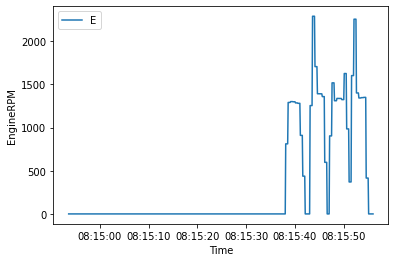

In [32]:
# 엔진속도를 시각화 
import matplotlib.pyplot as plt

plt.plot(df_phys_join["EngineRPM"])
plt.xlabel("Time")
plt.ylabel("EngineRPM")

plt.legend("E")
plt.show()